# Error analysis notebook

## Import packages

In [1]:
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch


## Set filepaths

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_default_nle_meta_9_1_theta=0.9.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_default_nle_meta_9_1_theta=0.9.tsv'
gt = '../pre_processing/resources/evaluation/2020/TREC-Fair-Ranking-eval-sample.json'

## Prepare dataframes

In [3]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result df
edf = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
edf = edf.pivot(index='qid', columns='key', values='value')

In [4]:
rdf.head(2)

,q_num,qid,ranking
0,0.0,9087,"[c68374b97eb2c214afd3c282175f664fc37c5682, 008..."
1,0.1,9087,"[cbc33164f9db97698901f130f399f2898d856267, 008..."


In [5]:
gtdf.head(2)

,qid,query,frequency,documents,doc_id,doc_rel
0,9087,lepidium sativum,0.000013,{'doc_id': '40d8bea494d4ff4c46f7ad5cb2dcdaa6f9...,40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4,1
0,9087,lepidium sativum,0.000013,{'doc_id': '008a2a2c765485af2e035a2572ba9fc110...,008a2a2c765485af2e035a2572ba9fc1102eabff,1


In [6]:
reldf.head(2)

,qid,query,doc_id,doc_rel
0,9087,lepidium sativum,40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4,1
0,9087,lepidium sativum,008a2a2c765485af2e035a2572ba9fc1102eabff,1


In [7]:
edf.head(2)

key,difference,disparity,relevance
qid,,,
95,0.351999,2.936763,1.949844
612,0.991691,1.731472,1.256254


## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. We do something similar by looking at queries for which the DGEE is lower than average. 

The worst ten queries are:

In [8]:
edf[edf.difference > edf.difference.mean()].sort_values(by='difference',ascending=False).head(10)

key,difference,disparity,relevance
qid,,,
657,3.700546,2.631709,0.255715
100510,3.252370,2.703133,0.514383
16607,3.034450,2.557715,0.550634
89881,1.987253,1.570899,0.577918
12885,1.941179,1.874742,0.848831
18060,1.725684,1.519402,0.684165
59483,1.619563,1.586472,0.469430
52501,1.429890,1.625181,0.943276
89569,1.210698,1.378091,0.572047


## Extract information for specific query

In [9]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [10]:
extract_results_based_on_qid(657, rdf).head(5)

,q_num,qid,ranking
24150,161.0,657,"[1436449e0234166b13135df45be1f072df059007, 863..."
24151,161.1,657,"[18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863..."
24152,161.2,657,"[e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79..."
24153,161.3,657,"[128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9..."
24154,161.4,657,"[e686c4e74d9085c78813355d582102d973b157cf, b79..."


In [11]:
extract_relevances_based_on_qid(657, reldf).head(5)

,qid,query,doc_id,doc_rel
161,657,iran,a1b0feb1f82716b0e343453ca214912cfd3ea0e5,0
161,657,iran,b59004dc46558189fa4d846029ccb1ce3f079484,0
161,657,iran,17475d93c5d0b5b6396aa1d3a3928d6154b65695,0
161,657,iran,1436449e0234166b13135df45be1f072df059007,0
161,657,iran,18f883bd5b9ab9771e561a0214af6bd5ddda0d61,0


## Visualization: rel/nonrel position distribution

We visualize how often a ranking position is occupied by a relevant versus a non-relevant document, aggregated over all 150 returned rankings for that query.


In [12]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    print(rel_counts)
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

In [13]:
def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)
    

In [14]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [15]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [16]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [17]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [18]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [19]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [20]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [21]:
def plot_rel_nonrel_per_rank_per_relkind(data,plotkind='bar'):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    
#     fig = plt.figure()
    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')
    
    if plotkind =='bar':
        sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],color=next(pi))
        sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],color=next(pi))
        
    if plotkind =='hist':
        sns.histplot(data=data[data.relkind=='r'], x="rank",weights=data[data.relkind=='r']["count"],binwidth=0.99,kde=True,ax=ax[0],color=next(pi))
        sns.histplot(data=data[data.relkind=='nr'], x="rank",weights=data[data.relkind=='nr']["count"],binwidth=0.99,kde=True,ax=ax[1],color=next(pi))

In [22]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, plotkind='bar'):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,plotkind=plotkind)
    

In [23]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
#     numrows = math.ceil(num_rel_docs / 2)
    fig, ax = plt.subplots(1, k, figsize = (18, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
        
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [24]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid, relevance)
                
        doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
        rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)
    
        fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k,rev)
        fig.suptitle(f"Document counts per rank for {qid}")
    
    

In [25]:
def plot_doc_pos_count(data):
    """Plot how many times each document occurred in the top and bottom positions."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={rel_count})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={nonrel_count})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos]
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)


In [26]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid,relevance)
        num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
        doc_position_counts = count_pos_of_documents(subranking, rel_count)
        doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
        plot_doc_pos_count(doc_pos_count_df)

    

In [27]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, plotkind='hist')
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, plotkind='bar')

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

In [28]:
plotoptions_qid = ["plot_rel_nonrel_per_rank_per_relkind_for_qid","plot_doc_occurrence_per_rank_for_qid","plot_doc_pos_count_for_qid"]

### QID: 657

In [29]:
qid = 657
subrdf = extract_results_based_on_qid(qid, rdf)
subreldf = extract_relevances_based_on_qid(qid,reldf)

In [30]:
rel_counts = subreldf.doc_rel.value_counts()
rel_count = rel_counts[1]
nonrel_count = rel_counts[0]

In [31]:
rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)

In [32]:
rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
rel_nonrel_df.head(4)

,rank,relkind,count
0,1,r,1
1,1,nr,149
2,2,r,7
3,2,nr,143


We plot the number of relevant/nonrelevant items that appear at each rank. An issue with this approach is that most rankings contain more nonrelevant than relevant items. As a result, there bars for the nonrelevant items are on a different scale than those for the relevant items. This makes the plot harder to read.

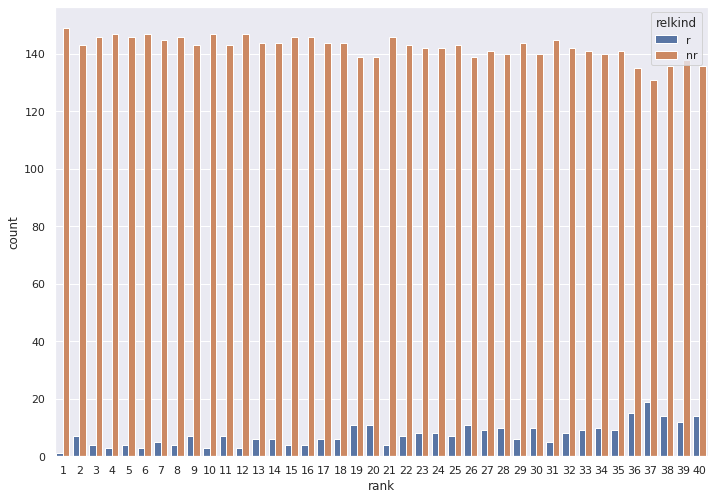

In [33]:
plot_rel_nonrel_per_rank(rel_nonrel_df)

We split the plot into relevant and nonrelevant item counts for readability.

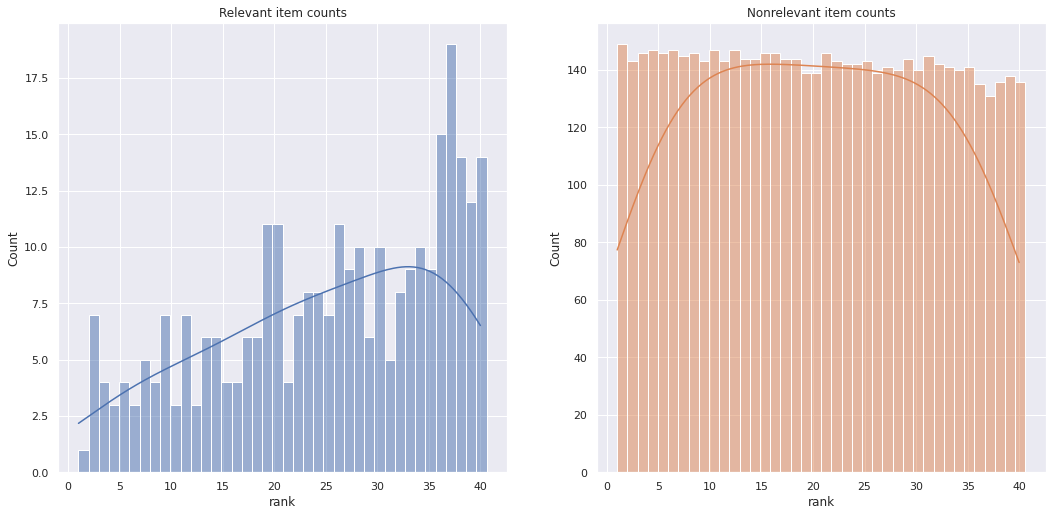

In [34]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,plotkind='hist')

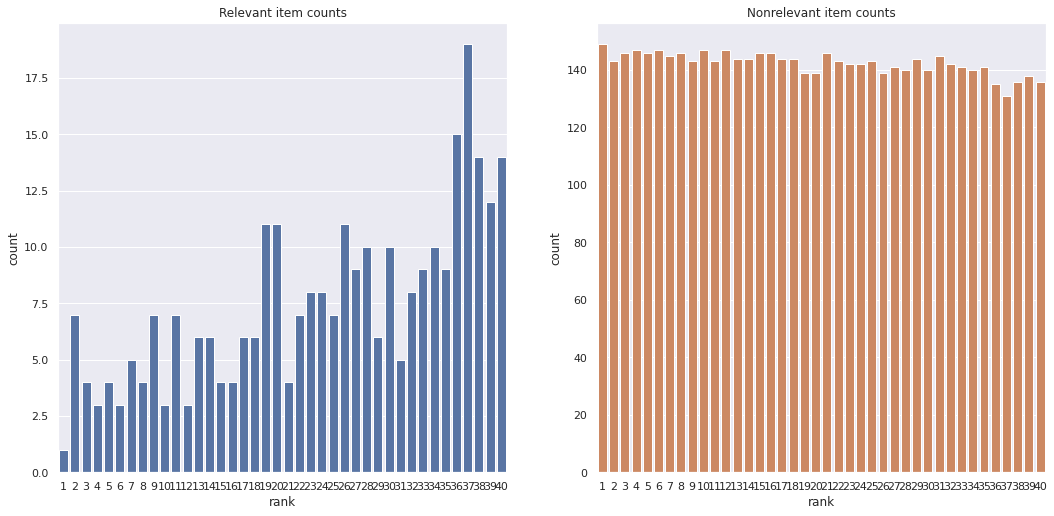

In [35]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,plotkind='bar')

We immediately see an interesting pattern in the distribution of the relevant items across the ranking positions. We see that the number of relevant items *increases* with increasing rank. This makes sense for a query that performs poorly, but we don't yet know *why* the relevant items are ranked towards the back. After all, if we ranked completely at random we would expect a uniform distribution instead.

In [36]:
doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)

In [37]:
rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts,subreldf)
rank_occurrence_df.head(4)

,rank,doc_id,count,doc_rel
0,1,1436449e0234166b13135df45be1f072df059007,7,0
1,1,18f883bd5b9ab9771e561a0214af6bd5ddda0d61,6,0
2,1,e9cfbf58d87e9f5afae813e8b8294b7719c176da,6,0
3,1,128611b63b268a1bffb69d3276a11ae7f6b068d7,5,0


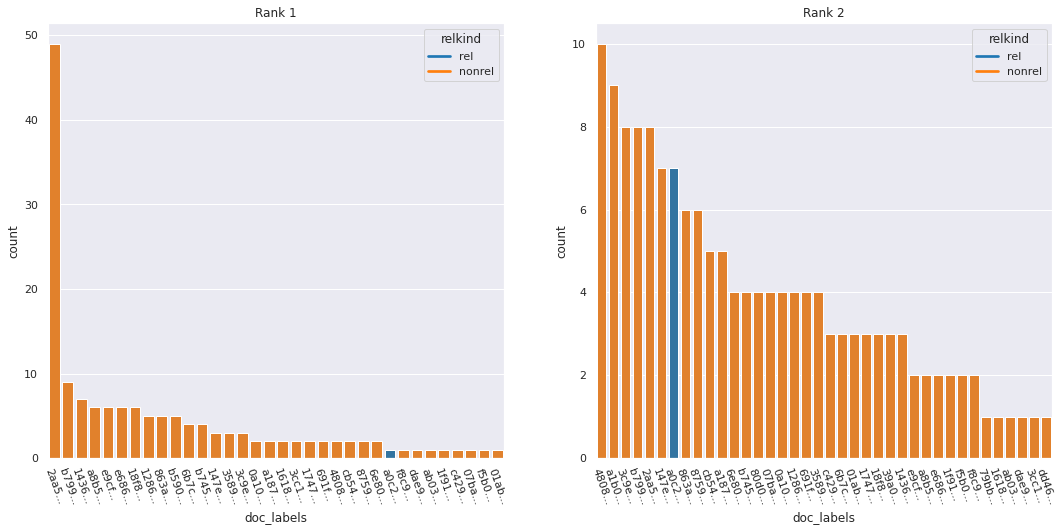

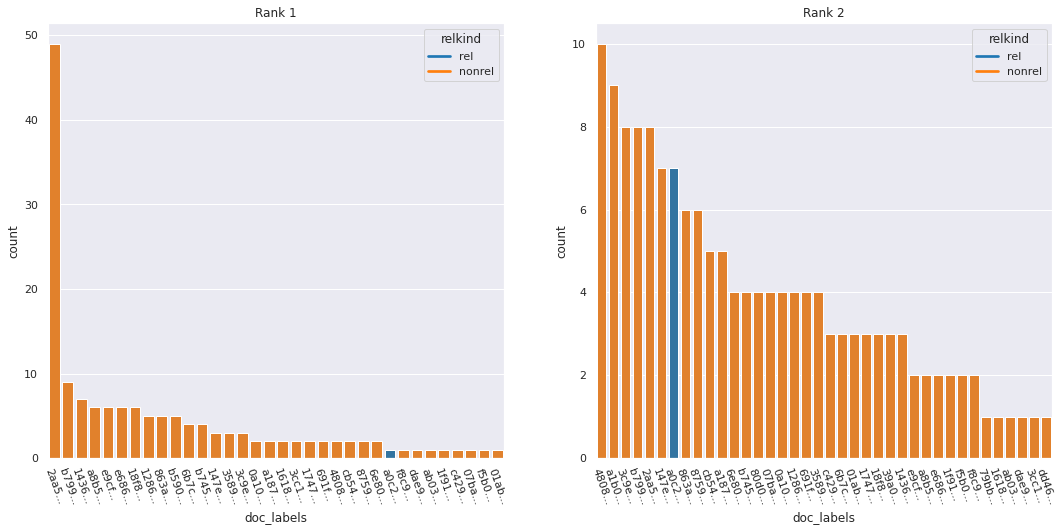

In [38]:
plot_doc_occurrence_per_rank(rank_occurrence_df,2)

In the figures above we see how many times each document was put in the first or second ranking position, aggregated across 150 rankings. The blue line indicates which document is relevant; only one relevant document is put in either the first or second rank, and only one time in the first and 5 times in the second ranking.

How often is each rel file in a top position? How often is it not?

In [39]:
subrdf.head(10)

,q_num,qid,ranking
24150,161.0,657,"[1436449e0234166b13135df45be1f072df059007, 863..."
24151,161.1,657,"[18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863..."
24152,161.2,657,"[e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79..."
24153,161.3,657,"[128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9..."
24154,161.4,657,"[e686c4e74d9085c78813355d582102d973b157cf, b79..."
24155,161.5,657,"[a8b58f310e13c171ce7b7890d23860836cbc4534, 143..."
24156,161.6,657,"[863a0360e4345b2e106e4f44cd95821f68b28036, 3c9..."
24157,161.7,657,"[87596955211a23714a6c2fc2af2d00464d15f9b3, 480..."
24158,161.8,657,"[3589a8b05684193dfc55610c9a9fbcf6db490130, 147..."
24159,161.9,657,"[6b7ca72ca79251cded87c47608e5cc93e37b09f2, b79..."


In [40]:
doc_position_counts = count_pos_of_documents(subrdf, rel_count)

In [41]:
doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subreldf)
doc_pos_count_df.head(10)

,doc_id,pos,count,doc_rel
0,1436449e0234166b13135df45be1f072df059007,top,10,0
1,1436449e0234166b13135df45be1f072df059007,bot,140,0
2,863a0360e4345b2e106e4f44cd95821f68b28036,top,11,0
3,863a0360e4345b2e106e4f44cd95821f68b28036,bot,139,0
4,e9cfbf58d87e9f5afae813e8b8294b7719c176da,top,8,0
5,e9cfbf58d87e9f5afae813e8b8294b7719c176da,bot,142,0
6,18f883bd5b9ab9771e561a0214af6bd5ddda0d61,top,9,0
7,18f883bd5b9ab9771e561a0214af6bd5ddda0d61,bot,141,0
8,3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec,top,11,0
9,3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec,bot,139,0


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


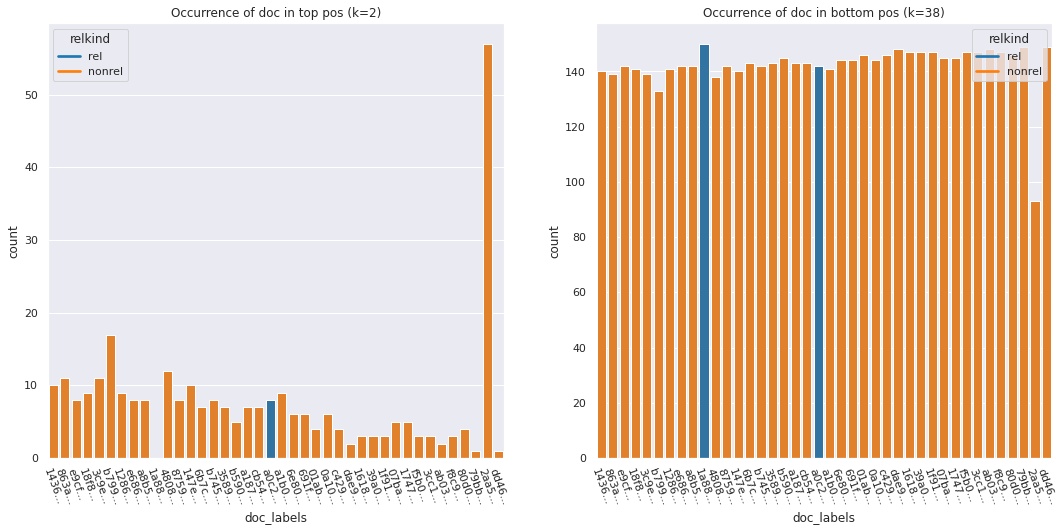

In [42]:
plot_doc_pos_count(doc_pos_count_df)


Let's compare multiple queries.

0    38
1     2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64


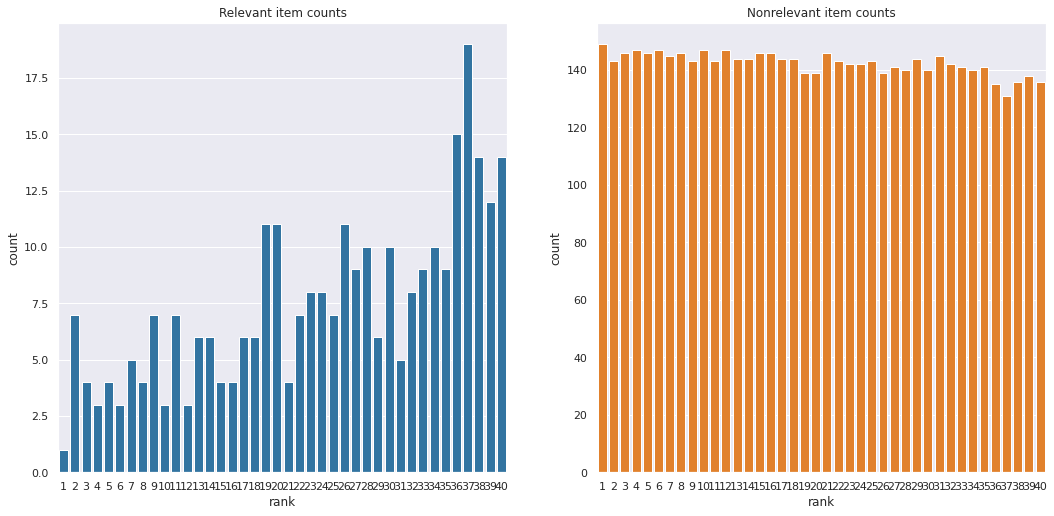

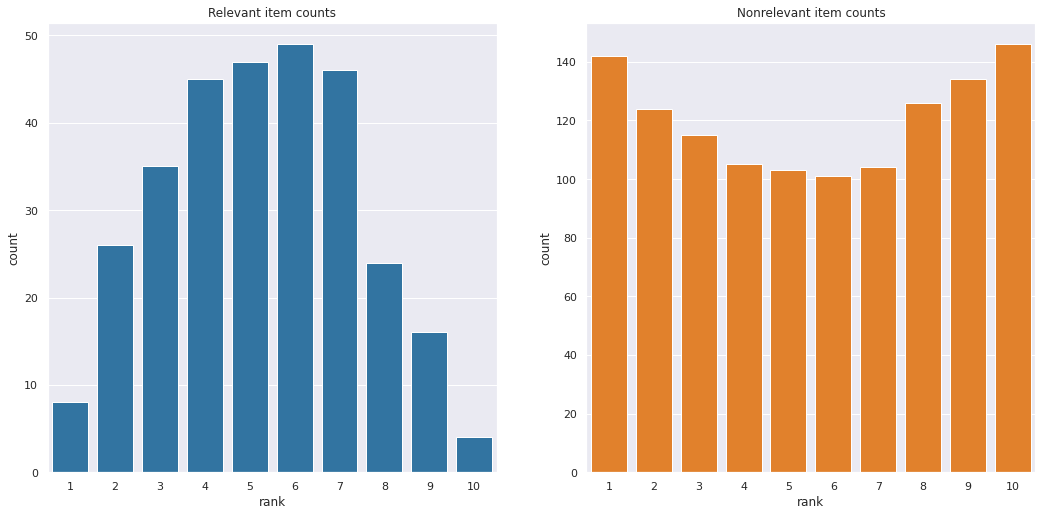

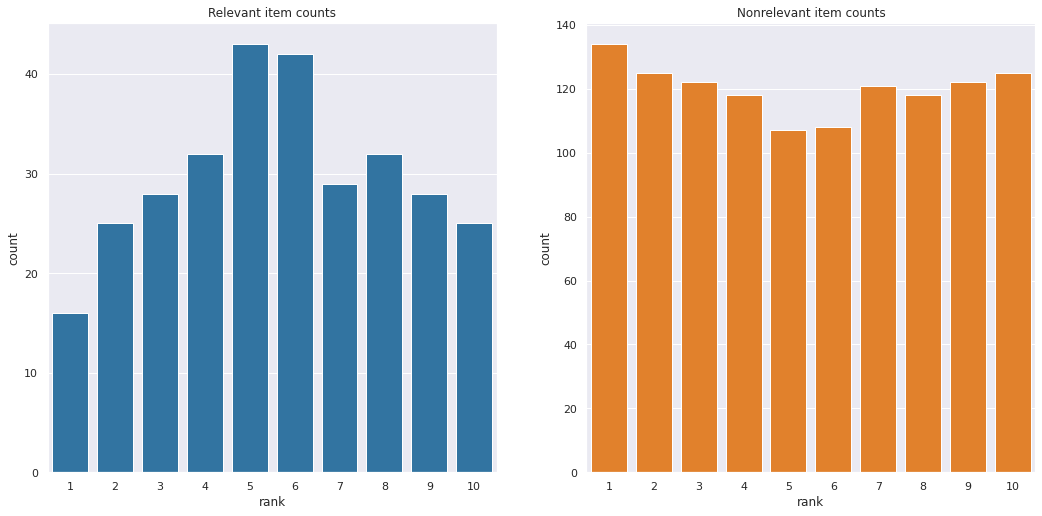

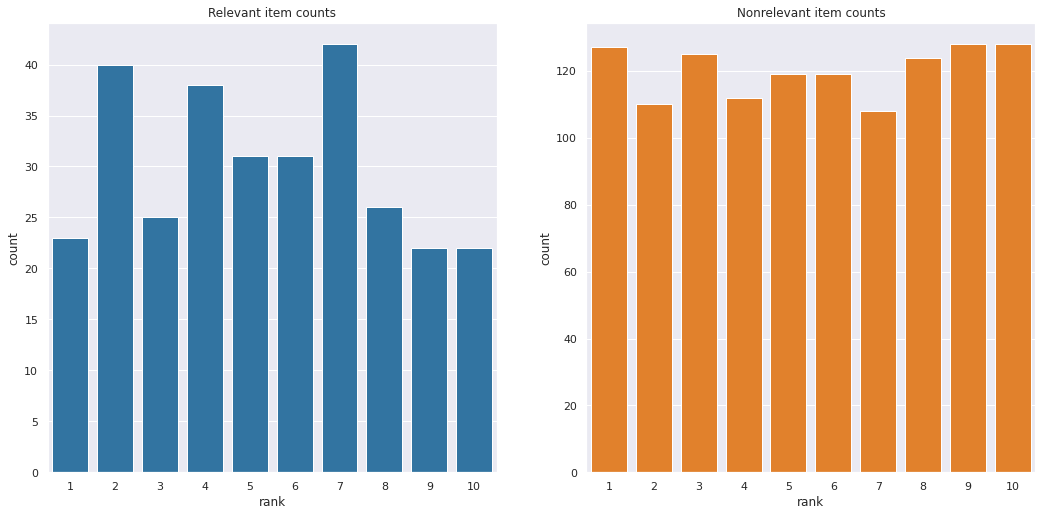

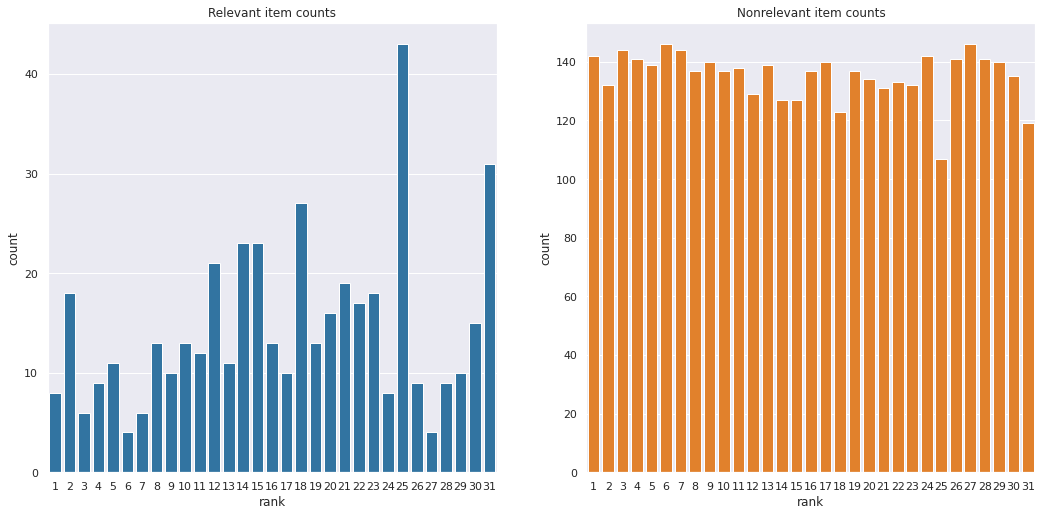

In [43]:
plot_rel_nonrel_per_rank_per_relkind_for_qid(657,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(100510,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(16607,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(89881,rdf,reldf)
plot_rel_nonrel_per_rank_per_relkind_for_qid(12885,rdf,reldf)


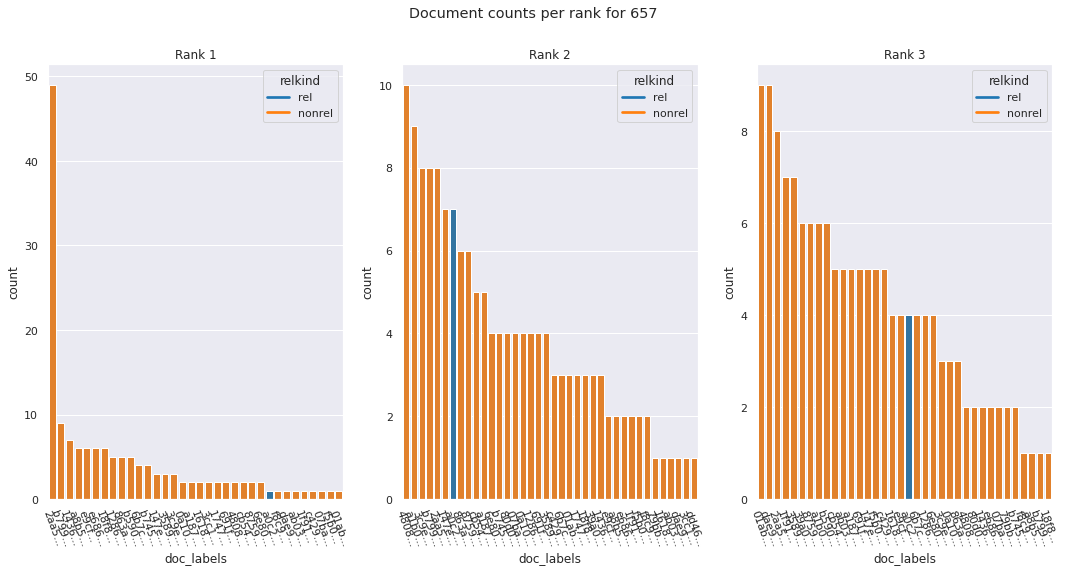

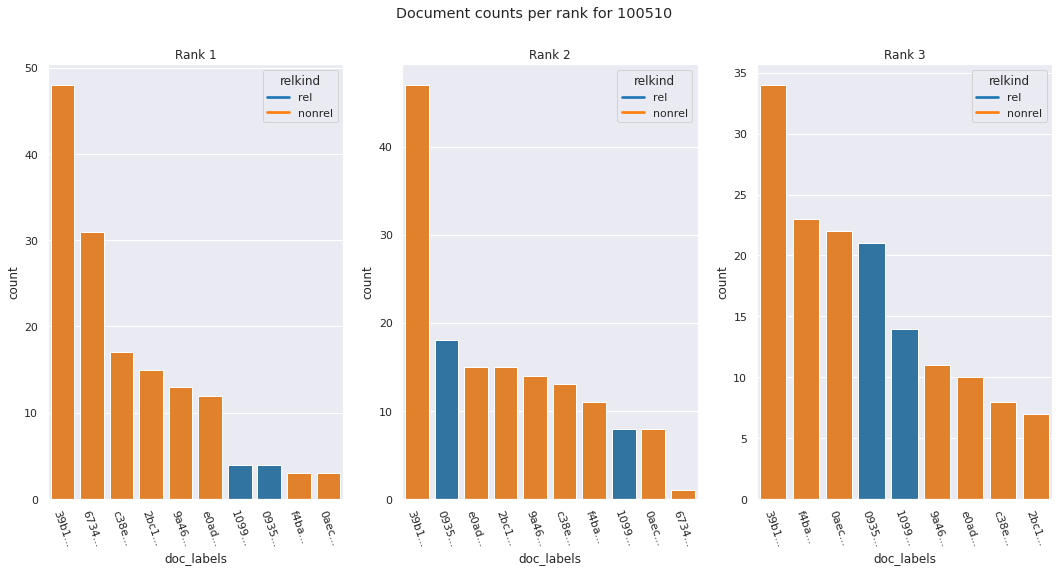

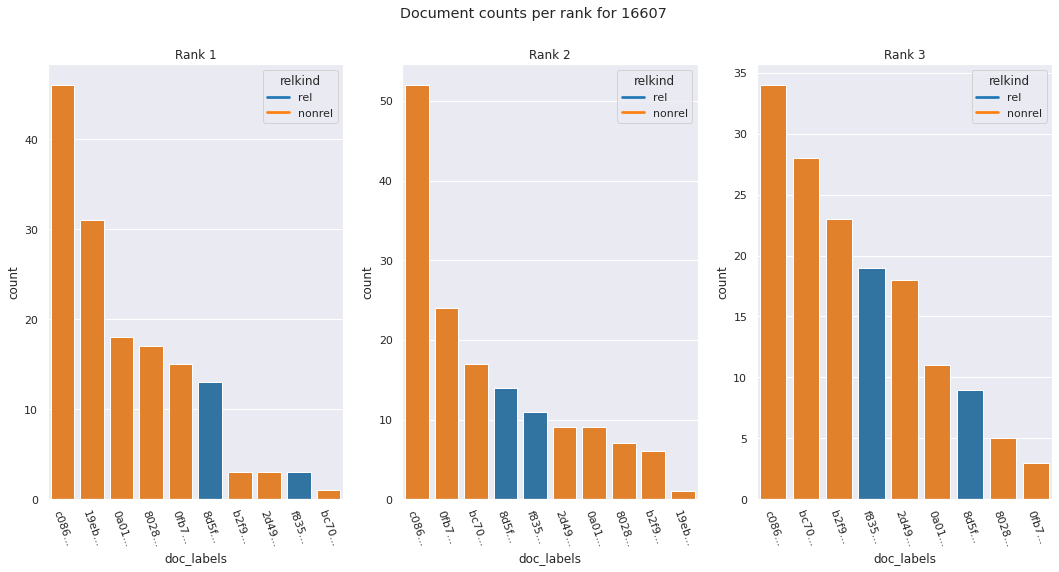

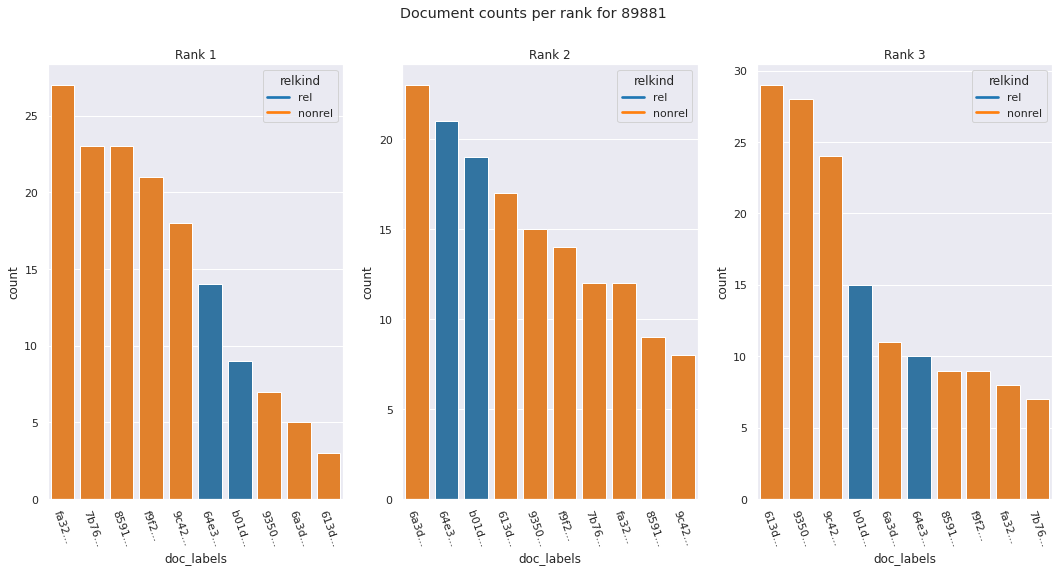

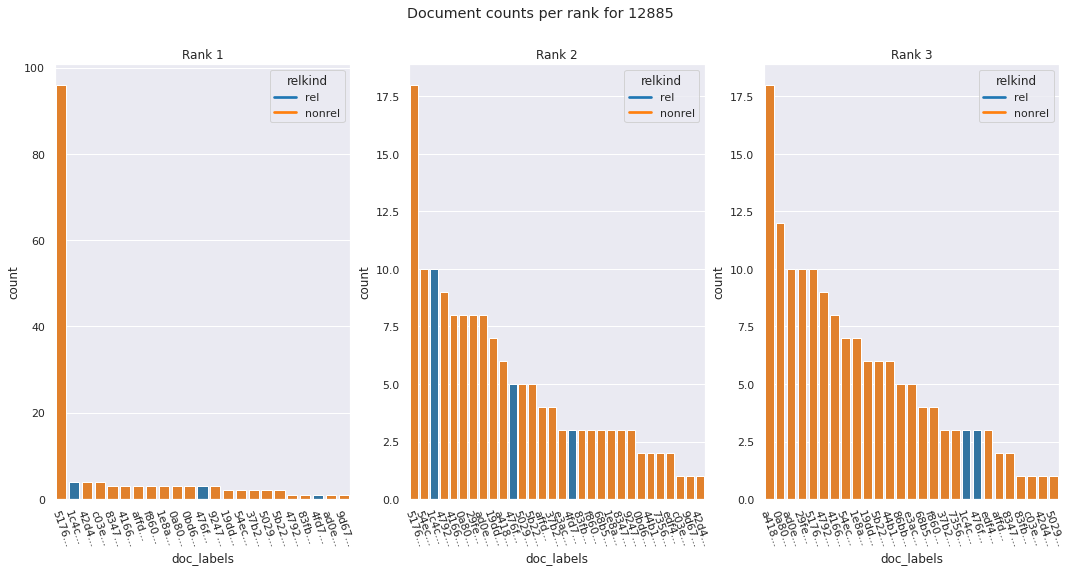

In [44]:
plot_doc_occurrence_per_rank_for_qid(657,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(100510,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(16607,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(89881,rdf,reldf,k=3)
plot_doc_occurrence_per_rank_for_qid(12885,rdf,reldf,k=3)


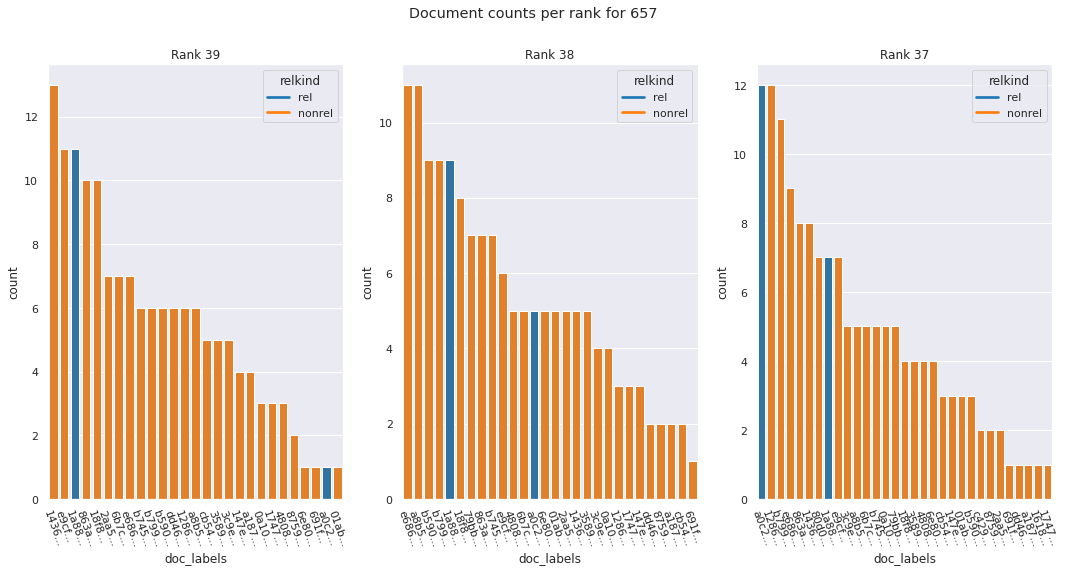

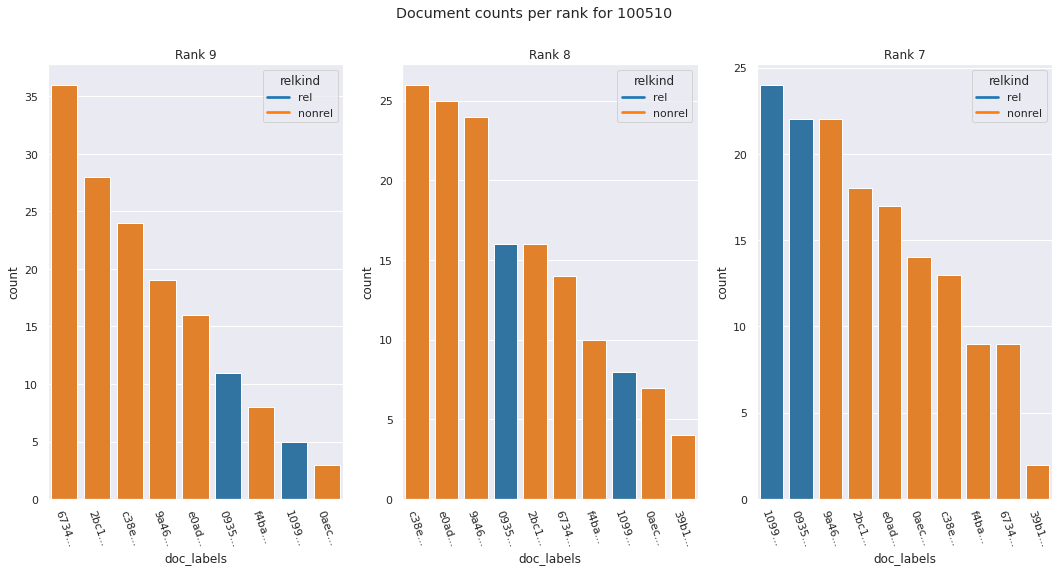

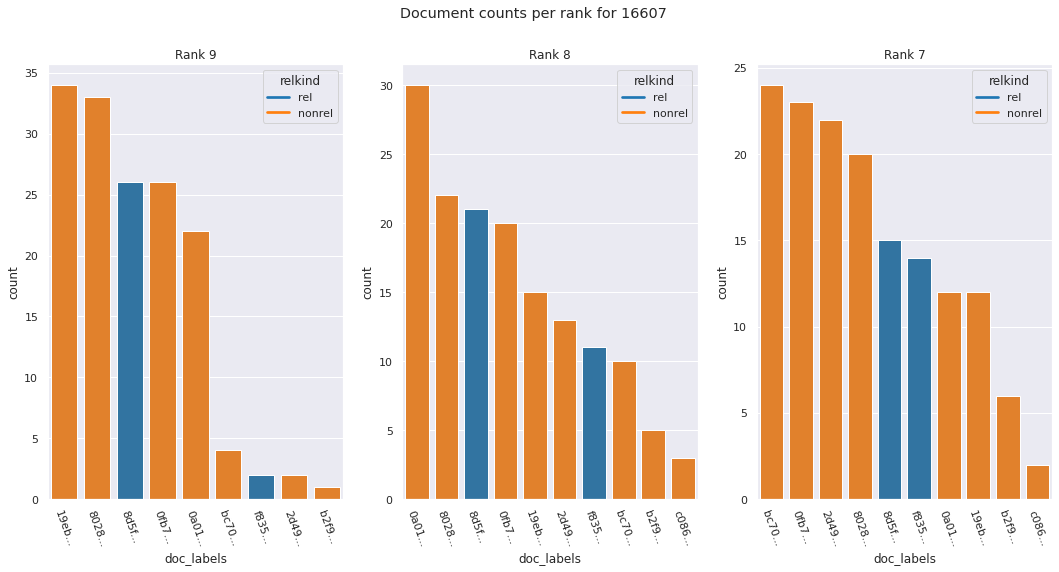

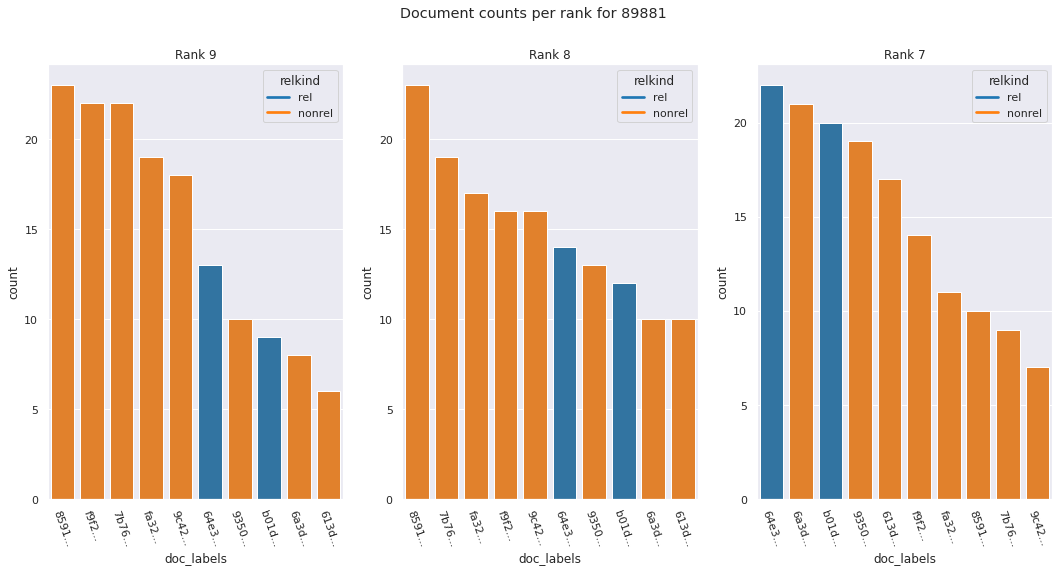

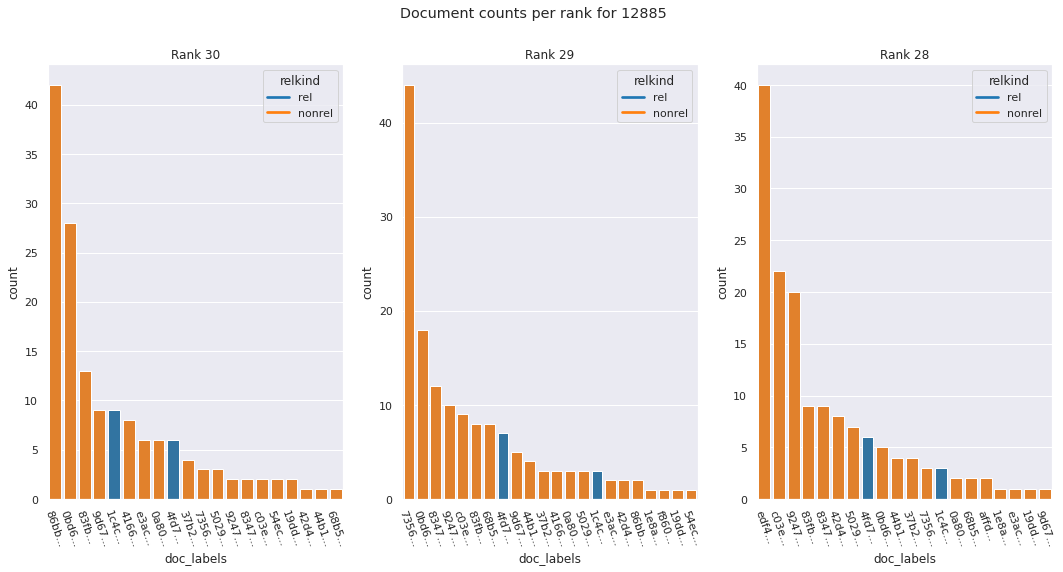

In [45]:
plot_doc_occurrence_per_rank_for_qid(657,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(100510,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(16607,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(89881,rdf,reldf,k=3,rev=True)
plot_doc_occurrence_per_rank_for_qid(12885,rdf,reldf,k=3,rev=True)


In [46]:
count_relgrades_qid(657,reldf)
count_relgrades_qid(100510,reldf)
count_relgrades_qid(16607,reldf)
count_relgrades_qid(89881,reldf)
count_relgrades_qid(12885,reldf)


0    38
1     2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    8
1    2
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64


(3, 28)

0    28
1     3
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64
0    28
1     3
Name: doc_rel, dtype: int64


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


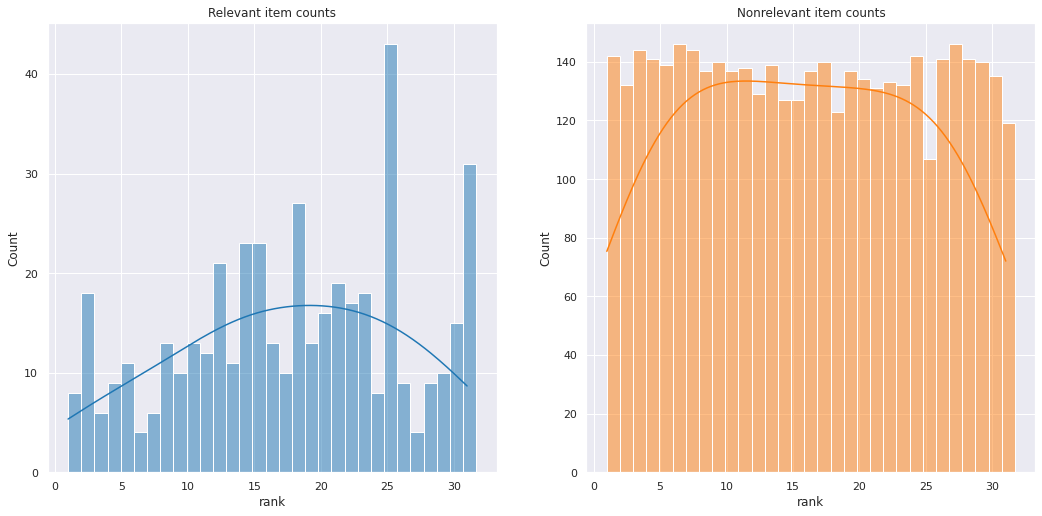

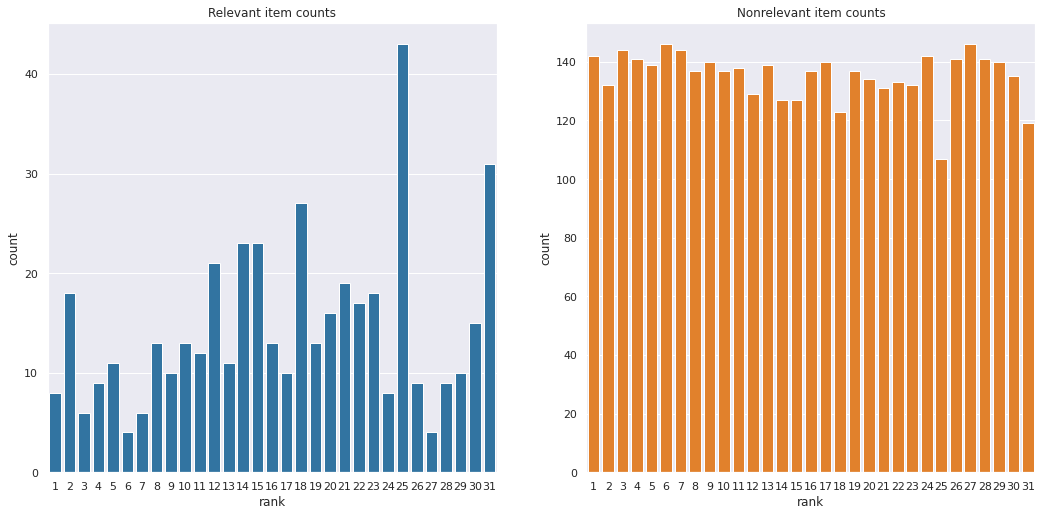

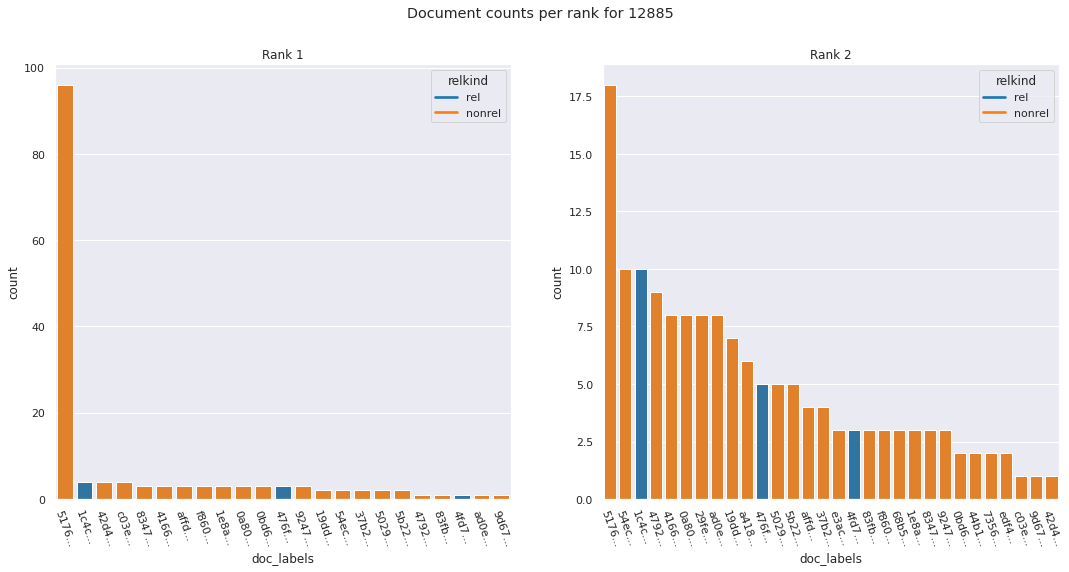

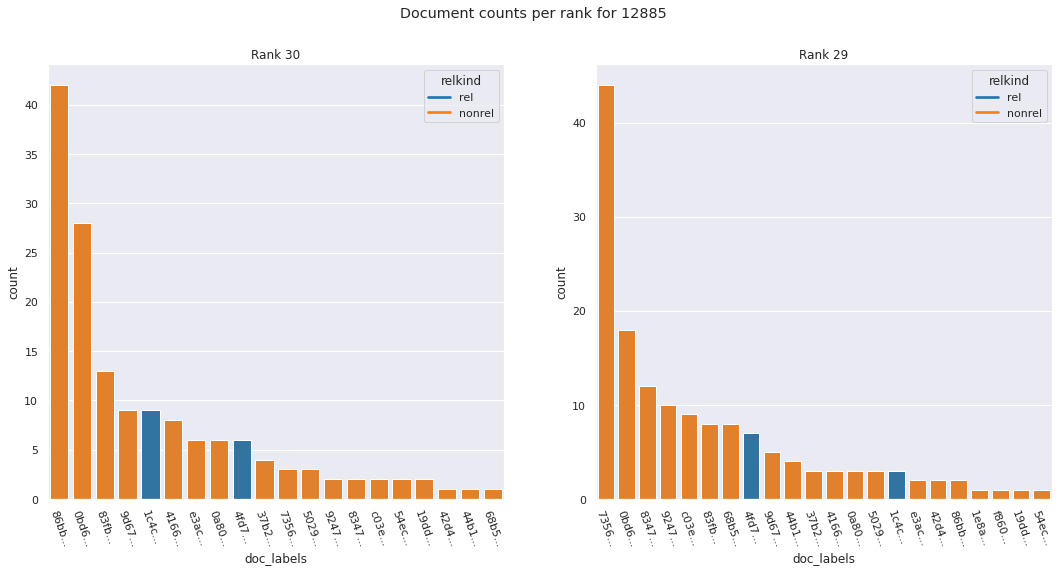

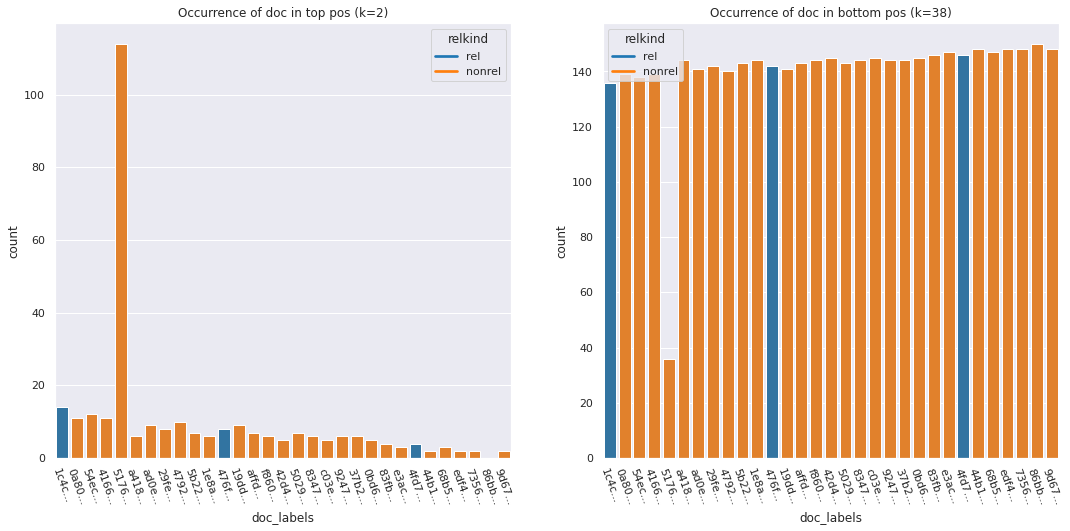

In [47]:
plots_for_qid(12885,rdf,reldf)

0    38
1     2
Name: doc_rel, dtype: int64
0    38
1     2
Name: doc_rel, dtype: int64
0    38
1     2
Name: doc_rel, dtype: int64


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


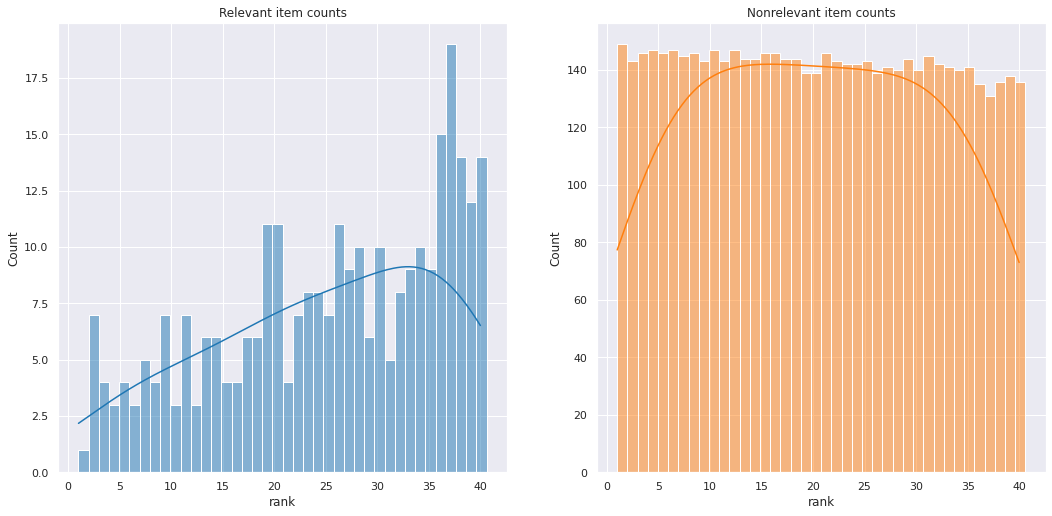

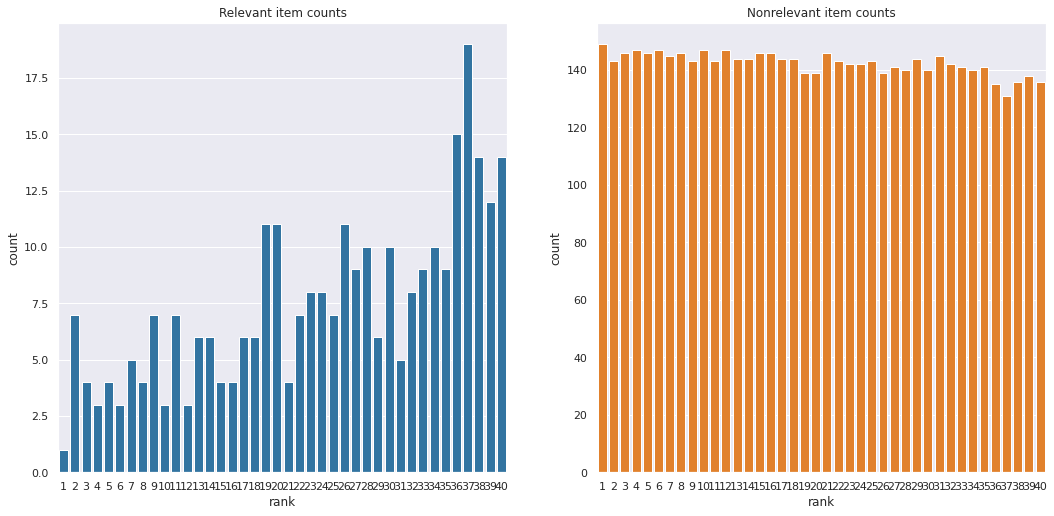

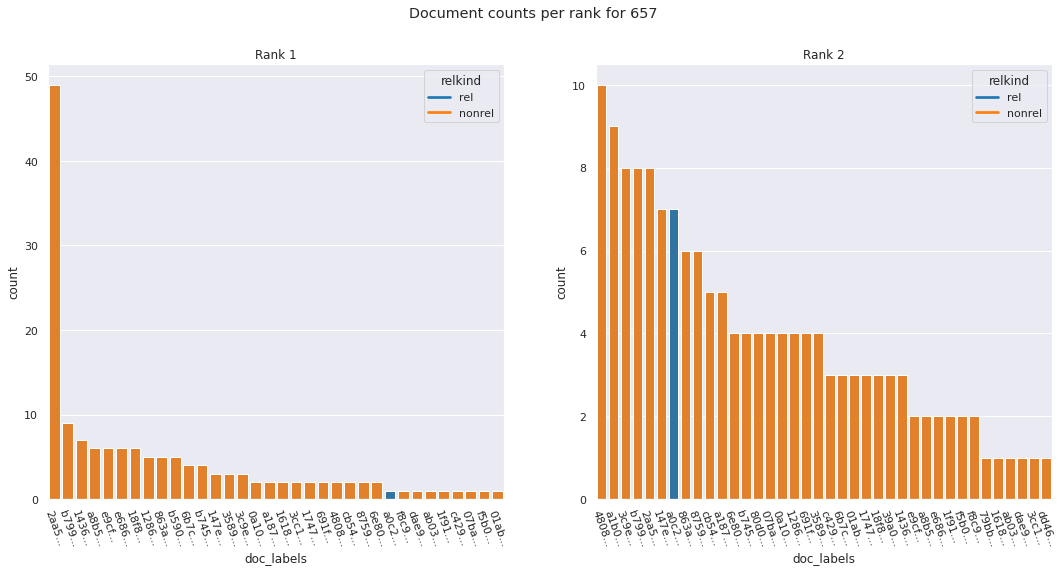

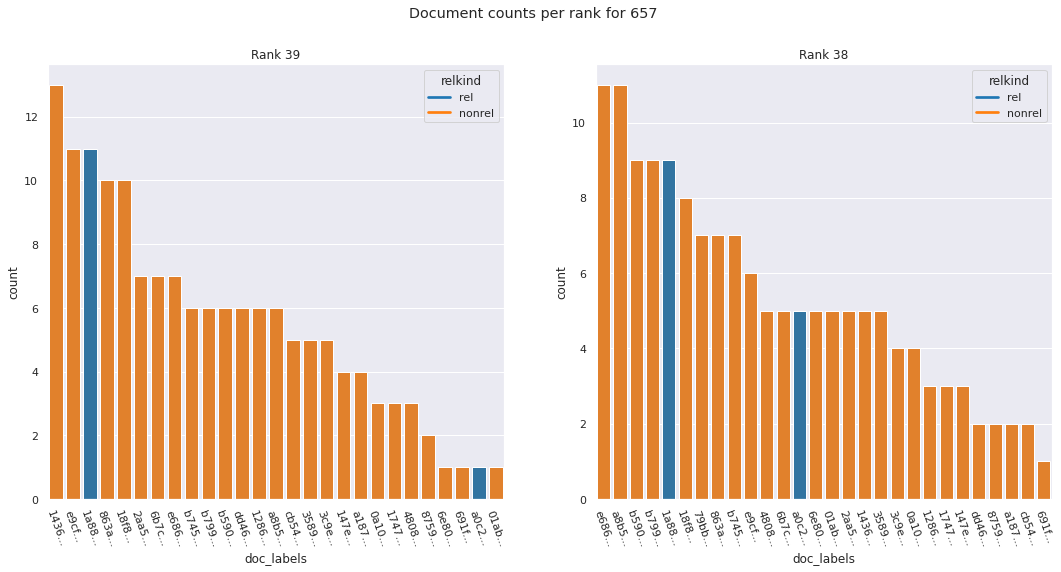

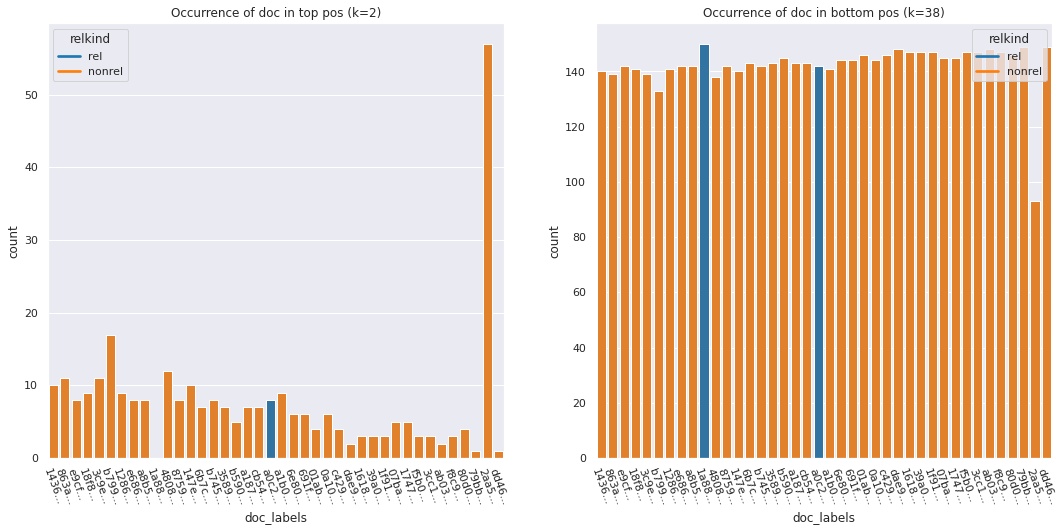

In [48]:
plots_for_qid(657,rdf,reldf)

In [49]:
reldf[(reldf.qid == 12885) & (reldf.doc_rel == 1)]

,qid,query,doc_id,doc_rel
141,12885,simulation,476f30d8ed96778b9de0d426d86e4133a9d0c3fc,1
141,12885,simulation,1c4c81d632eba2eae9733de143f83a34b911fa48,1
141,12885,simulation,4fd72cf38d951b2ae92fb1d9b705111335ef84ce,1


In [50]:
reldf[(reldf.qid == 657) & (reldf.doc_rel == 1)]

,qid,query,doc_id,doc_rel
161,657,iran,1a8800cdf999a01022f1db8e5c4c61306d3e43cc,1
161,657,iran,a0c27a04a05676559b89af279dd96dc4232ad4ce,1


In [51]:

es = Elasticsearch()


In [52]:
es.search(index='semanticscholar2020og', body={'size':10,'query':{'ids':{'values':['2aa5e431cd45476cc0432722dfa003a641790830']}}})


ConnectionError: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7f8365b10250>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7f8365b10250>: Failed to establish a new connection: [Errno 111] Connection refused)

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [ ]:
es.search(index='semanticscholar2020og', body={'size':10,'query':{'ids':{'values':['48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25']}}})

## Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.